# HBR transfer example

Welcome to this example/tutorial notebook that will go through the fitting, evaluation, transfering, and extending of HBR models. 

### Imports

In [1]:
# Need to install graphviz for the graphical model visualization
# %conda install -c conda-forge python-graphviz graphviz

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pcntoolkit.dataio.norm_data import NormData
from pcntoolkit.normative_model.norm_conf import NormConf
from pcntoolkit.normative_model.norm_hbr import NormHBR
from pcntoolkit.normative_model.norm_factory import load_normative_model
from pcntoolkit.normative_model.norm_factory import create_normative_model
from pcntoolkit.regression_model.hbr.hbr_conf import HBRConf
from pcntoolkit.regression_model.hbr.param import Param, make_param
from pcntoolkit.regression_model.hbr.hbr import HBR
from pcntoolkit.util.plotter import plot_centiles, plot_qq
import seaborn as sns
import arviz as az
import os

# Load data

First we download a small example dataset from github. Saving this dataset on your local device (under 'resources/data/fcon1000.csv' for example) saves time and bandwidth if you re-run this notebook.

In [3]:
# If you are running this notebook for the first time, you need to download the dataset from github.
# If you have already downloaded the dataset, you can comment out the following line
pd.read_csv(
    "https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/refs/heads/main/data/fcon1000.csv"
).to_csv("resources/data/fcon1000.csv", index=False)
data = pd.read_csv("resources/data/fcon1000.csv")
covariates = ["age"]
batch_effects = ["sex", "site"]
response_vars = ["rh_MeanThickness_thickness", "WM-hypointensities"]
norm_data = NormData.from_dataframe(
    name="full",
    dataframe=data,
    covariates=["age"],
    batch_effects=["sex", "site"],
    response_vars=["rh_MeanThickness_thickness", "WM-hypointensities"],
)

# Leave two sites out for doing transfer and extend later
transfer_sites = ["Milwaukee_b", "Oulu"]
transfer_data, fit_data = norm_data.split_batch_effects(
    {"site": transfer_sites}, names=["transfer", "fit"]
)

# Split into train and test sets
train, test = fit_data.train_test_split()
transfer_train, transfer_test = transfer_data.train_test_split()

## Configure the normative model

The normative model will be configured using a `NormConf` object, containing save and log paths and the preprocessing configurations, and a `RegConf` object, specific to the regression model type. 

Our `NormConf` object configures:
- a save path paths and whether to save the model and results
- a standardization step for both the covariates (inscaler) and the response vars (outscaler)
- a Bspline basis expansion of order 3 with 5 knots

In [4]:
# Create a NormConf object
norm_conf = NormConf(
    savemodel=True,
    saveresults=True,
    save_dir="resources/hbr/save_dir",
    inscaler="standardize",
    outscaler="standardize",
    basis_function="bspline",
    basis_function_kwargs={"order": 3, "nknots": 5},
)

Configuration of normative model is valid.


## Configure the regression model

HBR models need to specificy (possibly recursive) parameter configurations. Here, we configure a HBR model with a Normal likelihood, a bspline regression in `mu` and `sigma`, and a random effect in the intercept of `mu`. Note that because sigma has to be strictly positive, we specify a `softplus` mapping, so that the output of the linear regression is mapped to the positive domain. We also use the mapping_params to scale the mapping by a factor of 3, to avoid spikes in the resulting density. 

In [5]:
mu = make_param(
    name="mu",
    linear=True,
    slope=make_param(dist_name="Normal", dist_params=(0.0, 5.0)),
    intercept=make_param(
        random=True,
        sigma=make_param(dist_name="HalfNormal", dist_params=(1.0,)),
        mu=make_param(dist_name="Normal", dist_params=(0.0, 0.5)),
    ),
)
sigma = make_param(
    name="sigma",
    linear=True,
    slope=make_param(dist_name="Normal", dist_params=(0.0, 3.0)),
    intercept=make_param(
        dist_name="Normal",
        dist_params=(
            1.0,
            1.0,
        ),
    ),
    mapping="softplus",
    mapping_params=(0.0, 3.0),
)

epsilon = make_param(
    name="epsilon",
    dist_name="Normal",
    dist_params=(0.0, 1.0),
)

delta = make_param(
    name="delta",
    dist_name="Normal",
    dist_params=(0.0, 1.0),
    mapping="softplus",
    mapping_params=(0.0, 1.0, 0.3),
)


# Configure the HBRConf object
hbr_conf = HBRConf(
    draws=1500,
    tune=500,
    chains=4,
    pymc_cores=16,
    likelihood="SHASHb",
    mu=mu,
    sigma=sigma,
    epsilon=epsilon,
    delta=delta,
    nuts_sampler="nutpie",
)

## Combine normative and hbr conf in normative model
We can either use the NormHBR constructor, or the factory method to create a normative HBR model

In [6]:
# Using the constructor
norm_hbr = NormHBR(norm_conf=norm_conf, reg_conf=hbr_conf)
display(norm_hbr)
del norm_hbr

In [7]:
# Using the factory method
norm_hbr = create_normative_model(norm_conf, hbr_conf)
norm_hbr

In [8]:
predictions = norm_hbr.fit_predict(train, test)

Going to fit and predict 2 models
Fitting and predicting model for rh_MeanThickness_thickness


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.00,1023
,2000,0,0.00,1023
,2000,0,0.00,1023
,2000,0,0.00,1023


Sampling: [y_pred]


Output()

Fitting and predicting model for WM-hypointensities


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.01,1023
,2000,0,0.00,1023
,2000,0,0.00,1023
,2000,0,0.01,511


Sampling: [y_pred]


Output()

84529 Saving model to resources/hbr/save_dir


Sampling: [y_pred]


Output()

Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir/model
Computing zscores for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing zscores for WM-hypointensities


Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir/plots


## Inspecting the model 

The norm_hbr model contains a collection of regression models, one for each response variable. We can inspect those models individually by calling `norm_hbr.regression_models.get("{responsevar}")`

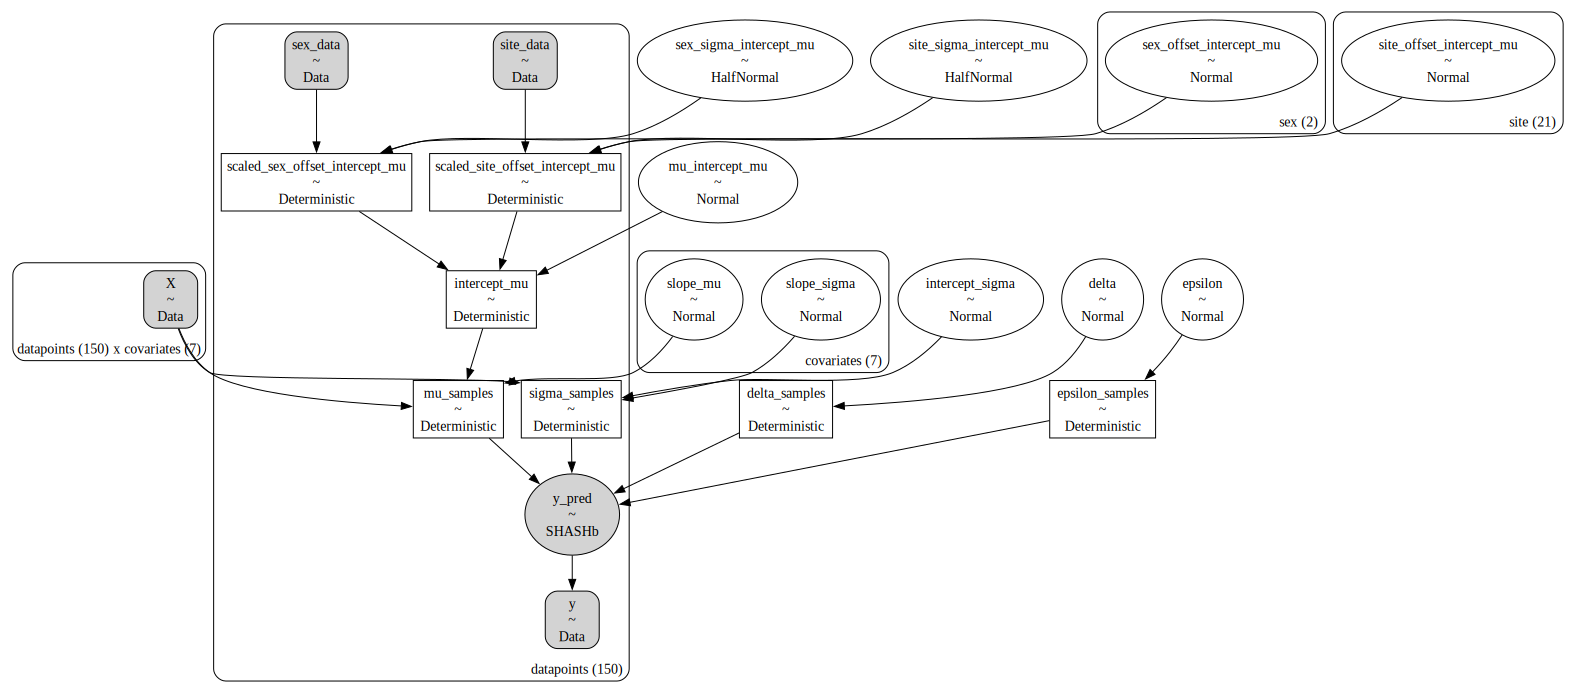

In [9]:
model: HBR = norm_hbr.regression_models.get("rh_MeanThickness_thickness")  # type: igno\re
model.pymc_model.to_graphviz()  # type: ignore

We can use the arviz library to inspect the posterior samples (trace) of the model. Here we only use the 'plot_trace' function to inspect the trace of the model, but there are many other useful functions available. If you are not familiar with arviz, we recommend checking out the [arviz documentation](https://arviz-devs.github.io/arviz/index.html).


<Figure size 640x480 with 0 Axes>

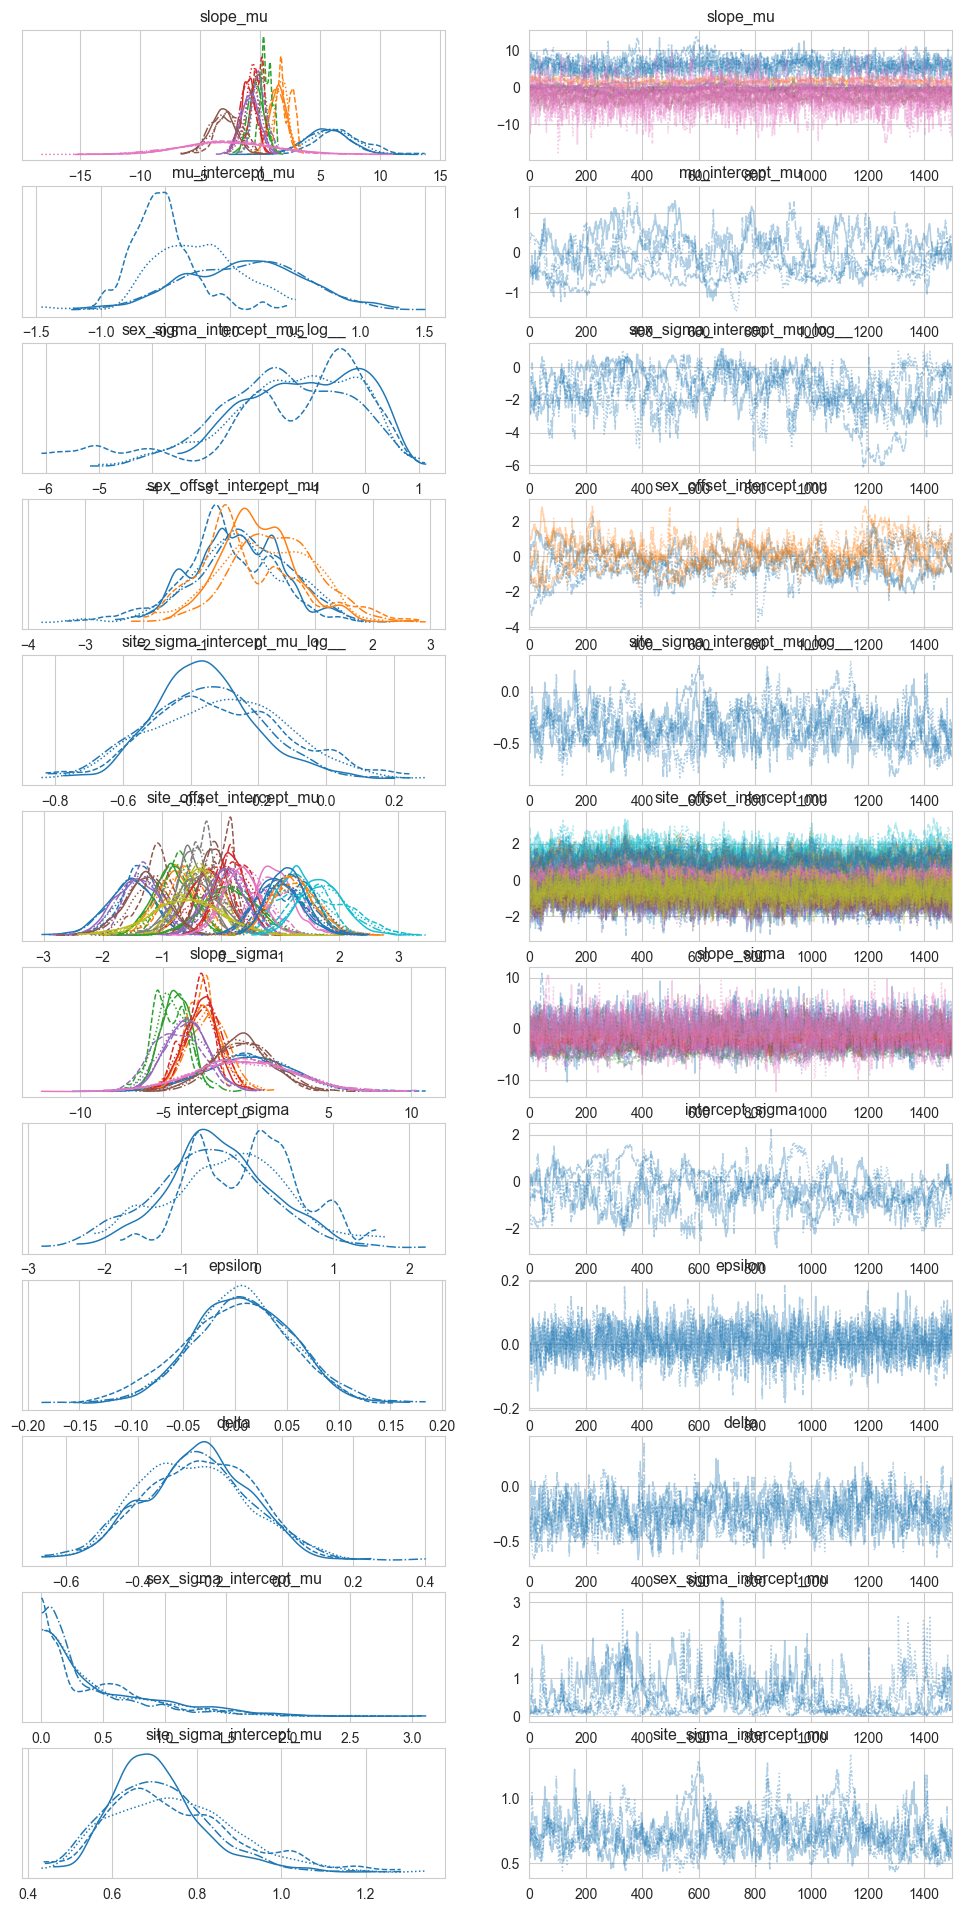

In [10]:
idata = model.idata  # type: ignore

plt.tight_layout()
az.plot_trace(
    idata.posterior,
    var_names=[
        "~mu_samples",
        "~sigma_samples",
        "~epsilon_samples",
        "~delta_samples",
        "~intercept_mu",
        "~scaled_site_offset_intercept_mu",
        "~scaled_sex_offset_intercept_mu",
    ],
)
plt.show()

## Evaluation
Calling `predict` will extend the predict_data object with a number of useful arrays.
1. `measures`: DataArray, which contains a number of evaluation statistics. 
1. `zscores`: the predicted z-scores for each datapoint.  
1. `centiles`: the predicted centiles of variation evaluated at each covariate in the dataset. 


In [11]:
display(test.measures.to_pandas().T)


response_vars,rh_MeanThickness_thickness,WM-hypointensities
statistics,,
Rho,0.556884,0.571767
RMSE,0.076183,530.922686
SMSE,0.649921,0.626299
ExpV,0.350269,0.441281
NLL,NaN,NaN
ShapiroW,0.990546,0.991413


Datasets with a zscores DataArray will have the `.plot_qq()` function available:

In [12]:
display(test.zscores.to_pandas())  # the zscores

response_vars,rh_MeanThickness_thickness,WM-hypointensities
datapoints,,
515,-0.670034,-0.329325
441,-0.313608,-0.419435
1029,1.322717,0.738432
64,-1.907572,0.385697
654,0.611204,-1.180727
...,...,...
611,-1.520958,1.678634
549,-1.543980,1.409487
640,-0.504659,-1.182230


In [13]:
display(test.centiles.to_dataframe().unstack(level=["response_vars", "cdf"]))

centiles                     \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.05               0.05   
datapoints                                                    
515                             2.380989         835.667916   
441                             2.374082         930.847132   
1029                            2.479310         563.425844   
64                              2.314540         555.615229   
654                             2.350101         343.668530   
...                                  ...                ...   
611                             2.360769         445.759646   
549                             2.233063         495.882389   
640                             2.296960         426.104419   
648                             2.376329         549.116300   
635                             2.487662         438.028433   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.25               0.25   
datapoints                                                    
515                             2.455906        1033.074256   
441                             2.446172        1119.447238   
1029                            2.548013         745.986853   
64                              2.383660         737.180924   
654                             2.430603         769.803391   
...                                  ...                ...   
611                             2.441386         845.992686   
549                             2.313565         922.017249   
640                             2.385701        1112.571055   
648                             2.454965         831.884532   
635                             2.559752         626.628539   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.50               0.50   
datapoints                                                    
515                             2.503775        1206.007856   
441                             2.492234        1284.688500   
1029                            2.591906         905.980081   
64                              2.427821         896.293556   
654                             2.482067        1143.057691   
...                                  ...                ...   
611                             2.492924        1196.550936   
549                             2.365028        1295.271550   
640                             2.442423        1714.036736   
648                             2.505228        1079.591678   
635                             2.605813         791.869801   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.75               0.75   
datapoints                                                    
515                             2.551860        1485.967061   
441                             2.538505        1552.211734   
1029                            2.636007        1165.026400   
64                              2.472189        1153.912529   
654                             2.533779        1747.064491   
...                                  ...                ...   
611                             2.544712        1763.846854   
549                             2.416740        1899.278350   
640                             2.499418        2686.915682   
648                             2.555740        1480.515427   
635                             2.652085        1059.393035   

                                                             
response_vars rh_MeanThickness_thickness WM-hypointensities  
cdf                                 0.95               0.95  
datapoints                                                   


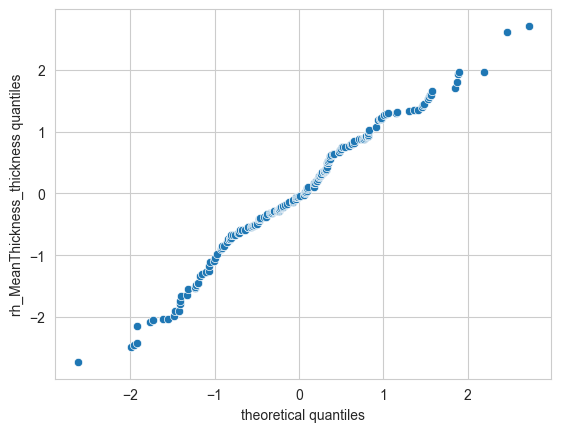

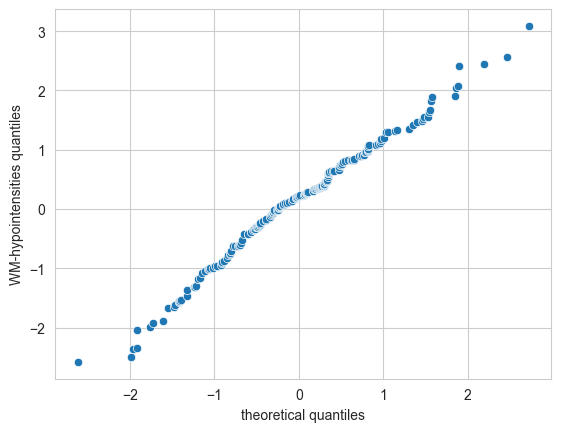

In [14]:
plot_qq(test)

And `plot_centiles()` can be called as a function of the model. A synthetic dataset is created internally, so we need to pass the original dataset (`train` in this case) as a template. We also need to pass which covariate is to be plotted on the x-axis, and the batch-effects for which the centiles are to be plotted. 

The lines correspond to the CDF values of: [0.05, 0.25, 0.5, 0.75, 0.95]. It is also possible to pass a list of CDF values to plot.

It may seem strange that the centiles do not match the plotted data, but that is because the centiles are calculated for a single batch effect, and it is superimposed on the full dataset. The blue markers correspond to the data for which the centiles are calculated. 

Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


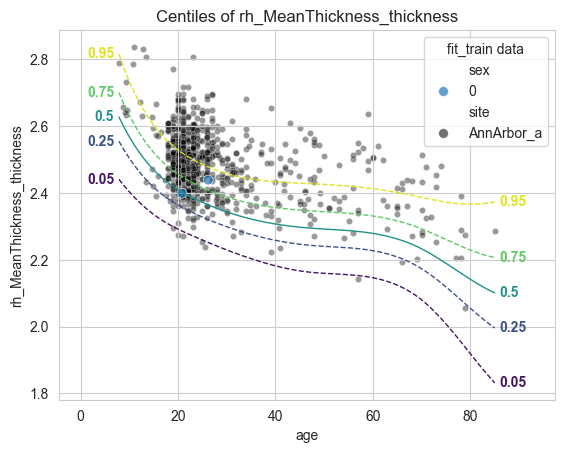

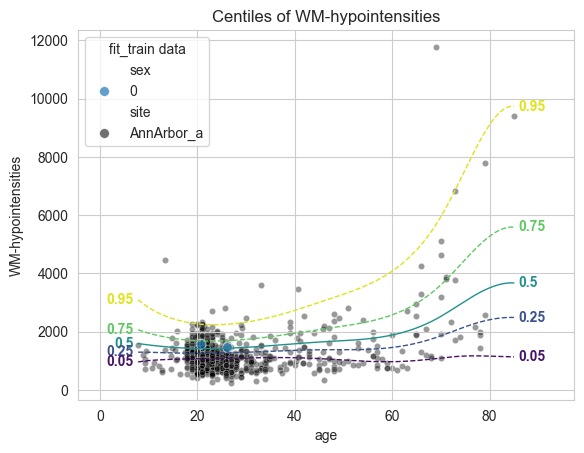

In [15]:
plot_centiles(
    norm_hbr,
    train,
    covariate="age",
    show_data=True,
    hue_data="sex",
    markers_data="site",
)

The values of 0.1587 and 0.8413 correspond to a standard deviation of -1 and 1. We plot the centiles again for these values, and we also highlight a specific site. 


Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


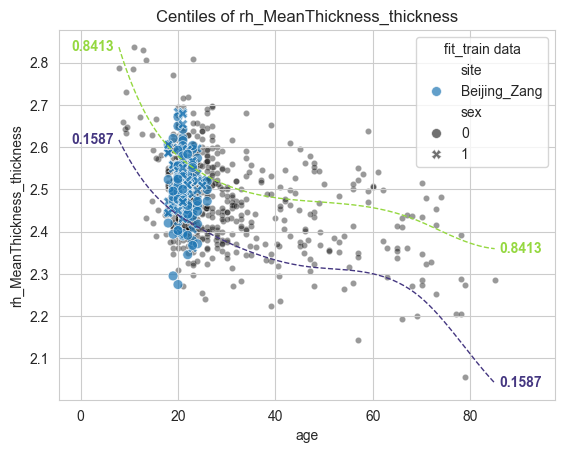

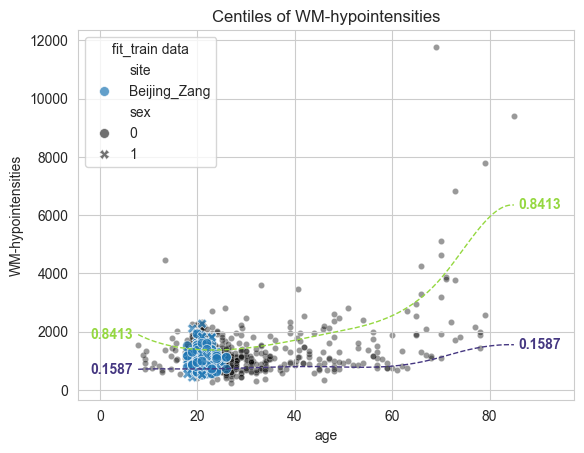

In [16]:
plot_centiles(
    norm_hbr,
    train,
    covariate="age",
    cummul_densities=[0.1587, 0.8413],
    show_data=True,
    batch_effects={"site": ["Beijing_Zang"]},
)

## Transfer

If we transfer to new dataset, we use the samples from the posterior to derive priors for a new model. That new model is then fitted on the new dataset. Our new model will not work on the old data. To give some extra control over the fit, we let the `freedom` parameter control the variance of the derived factorized posterior. Here we set it to something small (1e-4) to create a spike prior on the model parameters, to ensure that we do not 'forget' about what we learned from the original data. If we have a very large new dataset, we can set the freedom parameter to something bigger. 

In [17]:
transfered_model = norm_hbr.transfer_predict(
    transfer_train, transfer_test, freedom=1e-4, nuts_sampler="nutpie"
)

Going to transfer 2 models
Transferring model for rh_MeanThickness_thickness


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.55,7
,2000,0,0.49,7
,2000,0,0.55,7
,2000,0,0.59,7


Transferring model for WM-hypointensities


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.56,7
,2000,0,0.56,7
,2000,0,0.54,7
,2000,0,0.52,7


Configuration of normative model is valid.
84529 Saving model to resources/hbr/save_dir_transfer


Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

Predicting model for WM-hypointensities


Sampling: [y_pred]


Output()

Computing zscores for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir_transfer/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir_transfer/plots


We can save, load, predict, and plot just as before. 

If the orinal save directory path was `{path}/{save_dir}`, then the transfered model's save directory path will be `{path}/{save_dir}_tansfer`, and the same holds for the log dir path.

### Extend

Extending a model on new data amounts to using model to generate synthetic data according to the learned distribution, merging that with the new data, and fitting a new model on that merged dataset. This enables true federated learning, because the original data does not need to be shipped with the model to extend it to a new dataset. 

Because this is an extended model, we can make predictions on all sites, even those that were only present in the original data. 

In [18]:
extended_model = norm_hbr.extend_predict(transfer_train, norm_data)


Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

84529 - Going to fit 2 models

84529 - Fitting model for rh_MeanThickness_thickness



Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.00,1023
,2000,0,0.00,1023
,2000,0,0.00,1023
,2000,0,0.00,1023


84529 - Fitting model for WM-hypointensities



Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.00,1023
,2000,0,0.00,1023
,2000,0,0.00,1023
,2000,0,0.00,1023


84529 Saving model to resources/hbr/save_dir_extend


Sampling: [y_pred]


Output()

Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir_extend/model
Going to predict 2 models
Predicting model for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Predicting model for WM-hypointensities


Sampling: [y_pred]


Output()

Computing zscores for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing zscores for WM-hypointensities


Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir_extend/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir_extend/plots


And that's it, now you have seen how to:
- Use the NormData class to load in your data
- Create and fit a normative model
- Get the evaluation statistics, and create some useful plots
- Transfer the model to another dataset
- Extend the model to another dataset

We hope this tutorial was useful. If you have any questions or remarks, please let us know on GitHub. Thanks!